In [1]:
# Clear workspace
%reset

# standard packages
from math import e
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle as pkl
import os
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score, precision_recall_curve, plot_precision_recall_curve
from scipy.stats import sem
pd.options.display.max_colwidth = 100

# SGL packages
from group_lasso import LogisticGroupLasso
LogisticGroupLasso.LOG_LOSSES = True

%reload_ext autoreload
%autoreload 2

working_dir = "~/Desktop/hif2gene"


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
seed = 360
np.random.seed(seed)

## Load in HIFs + Clusters 

In [3]:
# Load in HIF dataset with labels
# NAs removed, already converted to patient-level
df = pd.read_csv("{0}/data/genetic_data/PanImmune/datasets/luad.PDL1.joined.USE.csv".format(working_dir))
df = df.iloc[:,1:]
df

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._HE,AREA..MM2..OF..ESI_0080..IN..TISSUE._HE,AREA..MM2..OF..NECROSIS..IN..TISSUE._HE,AREA..MM2..OF..STROMA..IN..TISSUE._HE,AREA..MM2..OF..TUMOR..IN..TISSUE._HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.STROMA_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.TUMOR_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.FIBROBLAST.IN.EPITHELIAL_HE,...,DENSITY..LYMPHOCYTE.CELLS..IN..TUMOR._HE,DENSITY..MACROPHAGE.CELLS..IN..EPITHELIAL._HE,DENSITY..MACROPHAGE.CELLS..IN..ESI_0080._HE,DENSITY..MACROPHAGE.CELLS..IN..STROMA._HE,DENSITY..MACROPHAGE.CELLS..IN..TUMOR._HE,DENSITY..PLASMA.CELLS..IN..EPITHELIAL._HE,DENSITY..PLASMA.CELLS..IN..ESI_0080._HE,DENSITY..PLASMA.CELLS..IN..STROMA._HE,DENSITY..PLASMA.CELLS..IN..TUMOR._HE,joined.PDL1_data
0,20.896096,9.596848,2.621136,6.091040,26.987136,7222.344601,5542.944608,4488.941632,7340.434434,6629.914323,...,363.247141,404.190333,726.488530,1033.156899,546.149099,60.633336,154.321502,199.473325,91.969744,1
1,33.297296,27.611440,2.688688,16.676464,49.973760,6827.908140,5818.064608,4838.977306,6909.248278,6038.370282,...,684.119026,187.883124,441.737193,758.014409,378.138447,342.370143,628.942207,671.725133,452.277355,1
2,16.196352,14.338432,5.292528,7.572624,23.768976,6421.250695,6239.398856,4833.440739,7046.967885,6479.620220,...,2280.914415,626.684330,1043.768245,1362.935754,861.248713,660.148656,840.538212,844.357253,718.836184,1
3,21.409056,7.647860,3.045184,3.017804,24.426860,7203.461019,5575.010000,2588.072893,7297.514648,6716.384490,...,260.328180,165.397297,465.228181,869.175069,252.345164,153.953542,338.395316,402.610640,184.673757,1
4,45.594784,11.333904,9.456400,3.525824,49.120608,6754.013440,4663.890074,4092.977594,7066.696147,6273.346550,...,153.031493,29.016477,141.875209,389.412517,54.885314,60.730631,167.815079,337.793378,80.617895,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,23.765936,57.329956,3.801792,72.332320,96.098256,6195.865412,6565.996038,5996.931267,6390.584961,5958.308663,...,2040.234736,139.569508,464.085477,686.387496,551.154643,267.525756,659.271394,828.661378,689.887650,1
291,63.962976,119.120184,26.983584,150.687472,214.650448,6459.409250,6545.221751,5078.486560,6529.722708,6316.402076,...,734.067883,295.764850,317.024359,423.207047,385.230969,207.291793,413.137374,771.809351,603.590634,0
292,1.333536,3.458368,1.725584,110.496016,111.829552,2268.824304,3221.368807,5159.867289,5058.554594,1519.343410,...,14784.696625,374.193123,671.414956,1084.030034,1075.565428,179.222758,511.512945,430.232706,427.239483,0
293,35.620352,35.469832,25.362688,23.217568,58.837920,5833.738689,6248.578618,5167.807759,5772.045809,5422.754758,...,773.905672,280.541866,288.160372,496.132928,365.614556,54.238655,206.739068,371.572079,179.459097,1


In [4]:
# Normalize HIFs and define X, y
X = df.iloc[:,:607]
X_normalized = (X-X.mean())/X.std()
X_normalized

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._HE,AREA..MM2..OF..ESI_0080..IN..TISSUE._HE,AREA..MM2..OF..NECROSIS..IN..TISSUE._HE,AREA..MM2..OF..STROMA..IN..TISSUE._HE,AREA..MM2..OF..TUMOR..IN..TISSUE._HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.STROMA_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.TUMOR_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.FIBROBLAST.IN.EPITHELIAL_HE,...,DENSITY..LYMPHOCYTE.CELLS..IN..STROMA._HE,DENSITY..LYMPHOCYTE.CELLS..IN..TUMOR._HE,DENSITY..MACROPHAGE.CELLS..IN..EPITHELIAL._HE,DENSITY..MACROPHAGE.CELLS..IN..ESI_0080._HE,DENSITY..MACROPHAGE.CELLS..IN..STROMA._HE,DENSITY..MACROPHAGE.CELLS..IN..TUMOR._HE,DENSITY..PLASMA.CELLS..IN..EPITHELIAL._HE,DENSITY..PLASMA.CELLS..IN..ESI_0080._HE,DENSITY..PLASMA.CELLS..IN..STROMA._HE,DENSITY..PLASMA.CELLS..IN..TUMOR._HE
0,-0.725939,-1.067297,-0.574697,-1.075333,-1.061052,0.971899,-0.831693,-1.320571,1.093752,1.089025,...,-0.684790,-0.611539,0.918176,2.126561,1.736157,0.626086,-0.588562,-1.034515,-1.156292,-1.122555
1,-0.466528,-0.762343,-0.571913,-0.872441,-0.792460,0.529441,-0.515896,-0.940149,0.464119,0.466857,...,-0.349545,-0.349995,-0.104656,0.623191,0.690197,-0.089754,1.392083,0.332143,-0.324928,-0.163208
2,-0.824250,-0.987030,-0.464626,-1.046935,-1.098656,0.073275,-0.032267,-0.946167,0.665222,0.930950,...,1.546558,0.951560,1.970263,3.801667,2.989819,1.968624,3.626106,0.941429,-0.021022,0.546525
3,-0.715209,-1.100290,-0.557225,-1.134238,-1.090969,0.950716,-0.794886,-3.386449,1.031079,1.179972,...,-0.842536,-0.695429,-0.210983,0.747214,1.112777,-0.625719,0.067490,-0.504479,-0.798684,-0.875723
4,-0.209286,-1.037892,-0.293060,-1.124501,-0.802429,0.446550,-1.840716,-1.750908,0.694030,0.713998,...,-0.811424,-0.782887,-0.855875,-0.959957,-0.711051,-1.467032,-0.587878,-0.995660,-0.912790,-1.152780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,-0.665907,-0.259262,-0.526050,0.194320,-0.253507,-0.179550,0.342618,0.318324,-0.293252,0.382650,...,0.529503,0.755381,-0.333113,0.741181,0.417906,0.647413,0.865918,0.419476,-0.048653,0.469447
291,0.174944,0.786733,0.429122,1.696162,1.131744,0.116079,0.318772,-0.679849,-0.090078,0.759282,...,-0.665554,-0.309281,0.405474,-0.035242,-0.582580,-0.059535,0.442465,-0.289261,-0.148737,0.239675
292,-1.135154,-1.171210,-0.611597,0.925808,-0.069691,-4.584693,-3.496516,-0.591404,-2.238330,-4.286124,...,9.352666,11.143445,0.776331,1.835795,1.929552,2.881759,0.245136,-0.005991,-0.750058,-0.229874
293,-0.417934,-0.629314,0.362335,-0.747067,-0.688884,-0.585764,-0.021730,-0.582774,-1.196465,-0.180630,...,-0.169347,-0.276810,0.333490,-0.187632,-0.305351,-0.143114,-0.633518,-0.883580,-0.853325,-0.889608


In [5]:
y = df.iloc[:,607]
print(np.sum(y))

170


In [6]:
# Load in clusters
clusters = pd.read_csv("{0}/data/hif_clusters/LUAD.hif.clusters.csv".format(working_dir))
print("Number of Clusters: {0}".format(len(set(clusters['x']))))
clusters


Number of Clusters: 20


,Unnamed: 0,x
0,AREA (MM2) OF [EPITHELIAL] IN [TISSUE]_HE,1
1,AREA (MM2) OF [ESI_0080] IN [TISSUE]_HE,1
2,AREA (MM2) OF [NECROSIS] IN [TISSUE]_HE,2
3,AREA (MM2) OF [STROMA] IN [TISSUE]_HE,1
4,AREA (MM2) OF [TUMOR] IN [TISSUE]_HE,1
...,...,...
602,TOTAL [MACROPHAGE CELLS] IN [TUMOR]_HE,1
603,TOTAL [PLASMA CELLS] IN [EPITHELIAL]_HE,20
604,TOTAL [PLASMA CELLS] IN [ESI_0080]_HE,1
605,TOTAL [PLASMA CELLS] IN [STROMA]_HE,1


## Define Nested CV Parameters

In [7]:
num_outer_loops = 3 # for estimating generalization error
num_inner_loops = 5 # for hyper-parameter tuning
training_aurocs = [0.0, 0.0, 0.0]
generalization_aurocs = [0.0, 0.0, 0.0]
training_auprcs = [0.0, 0.0, 0.0]
generalization_auprcs = [0.0, 0.0, 0.0]

# Define outer loops (A, B, and C)
X_train_AB, X_train_C, y_train_AB, y_train_C = train_test_split(X_normalized, y, test_size=1/3, random_state=seed, stratify=y)
X_train_A, X_train_B, y_train_A, y_train_B = train_test_split(X_train_AB, y_train_AB, test_size=1/2, random_state=seed, stratify=y_train_AB)

# Verify correctness
print(len(X_train_A), len(y_train_A))
print(len(X_train_B), len(y_train_B))
print(len(X_train_C), len(y_train_C))

print(np.sum(y_train_A)/len(y_train_A))
print(np.sum(y_train_B)/len(y_train_B))
print(np.sum(y_train_C)/len(y_train_C))

98 98
98 98
99 99
0.5816326530612245
0.5714285714285714
0.5757575757575758


### Outer Loop 1

In [10]:
# Define outer loop train and test
X_train_1 = np.array(X_train_A.append(X_train_B))
y_train_1 = np.array(y_train_A.append(y_train_B))
print(X_train_1.shape, y_train_1.shape)

X_test_1 = np.array(X_train_C)
y_test_1 = np.array(y_train_C)
print(X_test_1.shape, y_test_1.shape)

(196, 607) (196,)
(99, 607) (99,)


In [9]:
# Define k-folds object
skf = StratifiedKFold(n_splits=num_inner_loops)
skf.get_n_splits(X_train_1, y_train_1)

5

In [ ]:
# K-folds: hyper-parameter tuning
num_regs = 30
regs = list(np.logspace(-7, -2, num_regs, base=e))
print(regs)

cv_aucs = [] # based on k-folds CV

for reg in regs:
    print(reg)
    k_folds_count = 1
    
    aucs = [] 
    for train_index, test_index in skf.split(X_train_1, y_train_1):
        print(k_folds_count)

        # Define train / test
        X_train, X_test = X_train_1[train_index], X_train_1[test_index]
        y_train, y_test = y_train_1[train_index], y_train_1[test_index]
        print(np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test))
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        
        # SGL 
        sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=reg*(1/6), l1_reg=reg*(5/6), n_iter=1000, 
                                 tol=1e-6, old_regularisation=False, warm_start=True, random_state=seed)
        sgl.fit(X_train, y_train)

        # Compute AUC on test set
        y_probs_test = sgl.predict_proba(X_test)[1] # predicted probability y = 1
        fpr, tpr, thresholds = roc_curve(y_test, y_probs_test, pos_label=1)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        k_folds_count += 1
    
    print(aucs)
    cv_aucs.append(np.mean(np.array(aucs)))

[0.625660606060606, 0.6068107744107744, 0.6147070707070708, 0.6094020202020203, 0.6110666666666668, 0.6238599326599326, 0.6039811447811447, 0.6184565656565657, 0.6484983164983165, 0.6599649831649831, 0.659173063973064, 0.6762329966329966, 0.6081508417508419, 0.6185023569023569, 0.6115595959595959, 0.6326101010101011, 0.6499838383838383, 0.665437037037037, 0.6468565656565656, 0.6549319865319865, 0.6799851851851851, 0.6765387205387206, 0.6717225589225588, 0.6866047138047138, 0.6919784511784511, 0.5743151515151516, 0.5, 0.5, 0.5, 0.5]


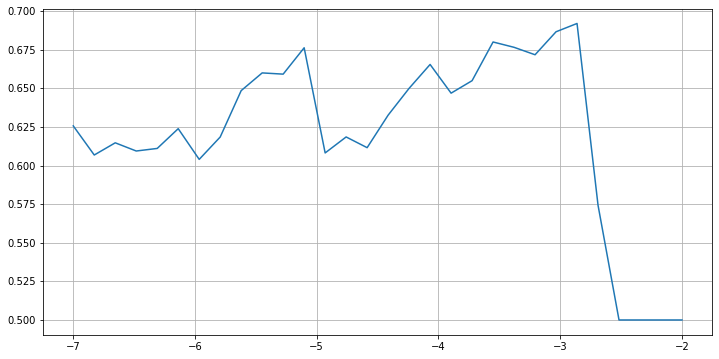

0.0571503956636256 -2.862068965517241


In [12]:
# Plot CV AUCs
print(cv_aucs)
plt.figure(figsize=(12,6))
plt.plot(np.log(regs), cv_aucs)
plt.grid(axis='both')
plt.show()

max_reg = regs[np.argmax(np.array(cv_aucs))]
print(max_reg, np.log(max_reg))

In [ ]:
# Choose best regularization parameter based on CV plot
optimal_log_reg = -3.6
optimal_reg = np.exp(optimal_log_reg)
print(optimal_log_reg, optimal_reg)

# Fit "optimal model"
optimal_sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=optimal_reg*(1/6), l1_reg=optimal_reg*(5/6), n_iter=1000, 
                         tol=1e-6, old_regularisation=False, warm_start=False, random_state=seed)
optimal_sgl.fit(X_train_1, y_train_1)

# Store optimal model
optimal_sgl_1 = optimal_sgl

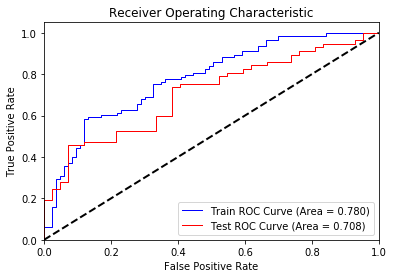

In [12]:
# Plot Train and Test ROCs
y_pred_probs_train = optimal_sgl.predict_proba(X_train_1)[1] # predicted probability y = 1
y_pred_probs_test = optimal_sgl.predict_proba(X_test_1)[1]

# Train
fpr, tpr, thresholds = roc_curve(y_train_1, y_pred_probs_train, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=1, label='Train ROC Curve (Area = %0.3f)' % roc_auc)
training_aurocs[0] = roc_auc

# Test
fpr, tpr, thresholds = roc_curve(y_test_1, y_pred_probs_test, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Test ROC Curve (Area = %0.3f)' % roc_auc)
generalization_aurocs[0] = roc_auc

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

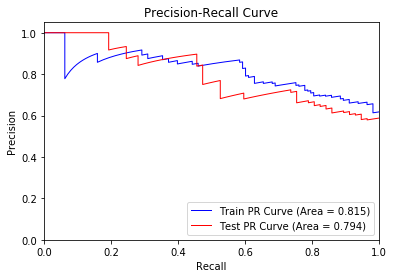

In [13]:
# Plot Train and Test PR Curves

# Train
precision, recall, thresholds = precision_recall_curve(y_train_1, y_pred_probs_train, pos_label=1)
prc_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='blue', lw=1, label='Train PR Curve (Area = %0.3f)' % prc_auc)
training_auprcs[0] = prc_auc

# Test
precision, recall, thresholds = precision_recall_curve(y_test_1, y_pred_probs_test, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Test PR Curve (Area = %0.3f)' % prc_auc)
generalization_auprcs[0] = prc_auc

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [14]:
# Save model coefficients
sparsity_mask = optimal_sgl.sparsity_mask_
print("Number of chosen variables: {0}".format(sparsity_mask.sum()))

betas_1 = optimal_sgl.coef_[:, 1] - optimal_sgl.coef_[:, 0]
betas_1[~sparsity_mask] = 0.0 # if not included in model, set to 0
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta": betas_1, 
    "Cluster": clusters['x'],
    "Included (T/F)": sparsity_mask}
)
betas_df = betas_df[betas_df['Included (T/F)'] == True][['HIF', 'Beta', 'Cluster']]
betas_df.sort_values(by="Beta", ascending=False)

Number of chosen variables: 81


,HIF,Beta,Cluster
242,COUNT PROP [PLASMA CELLS] IN [[STROMA] OVER [EPITHELIAL]]_HE,0.173808,15
475,REGION PROPERTIES: LACUNARITY OF LARGEST REGION OF NECROSIS_HE,0.123370,11
154,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION MEAN OF FIBROBLAST IN STROMA_HE,0.116138,13
94,CELL CLUSTERING PROPERTIES: CLUSTER SIZE MEAN OF FIBROBLAST IN STROMA_HE,0.074171,13
174,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION STANDARD DEVIATION OF FIBROBLAST IN STROMA_HE,0.061929,13
...,...,...,...
195,COUNT PROP [CANCER CELLS] IN [[STROMA] OVER [ESI_0080]]_HE,-0.082925,11
443,REGION PROPERTIES: ECCENTRICITY OF LARGEST REGION OF NECROSIS_HE,-0.084308,19
225,COUNT PROP [MACROPHAGE CELLS] IN [[EPITHELIAL] OVER [STROMA]]_HE,-0.109467,15
220,COUNT PROP [LYMPHOCYTE CELLS] IN [[STROMA] OVER [TUMOR]]_HE,-0.139418,15


### Outer Loop 2

In [15]:
# Define outer loop train and test
X_train_2 = np.array(X_train_A.append(X_train_C))
y_train_2 = np.array(y_train_A.append(y_train_C))
print(X_train_2.shape, y_train_2.shape)

X_test_2 = np.array(X_train_B)
y_test_2 = np.array(y_train_B)
print(X_test_2.shape, y_test_2.shape)

(197, 607) (197,)
(98, 607) (98,)


In [22]:
# Define k-folds object
skf = StratifiedKFold(n_splits=num_inner_loops)
skf.get_n_splits(X_train_2, y_train_2)

5

In [ ]:
# K-folds: hyper-parameter tuning
num_regs = 30
regs = list(np.logspace(-6.0, -3.0, num_regs, base=e))
print(regs)

cv_aucs = [] # based on k-folds CV

for reg in regs:
    print(reg)
    k_folds_count = 1
    
    aucs = [] 
    for train_index, test_index in skf.split(X_train_2, y_train_2):
        print(k_folds_count)

        # Define train / test
        X_train, X_test = X_train_2[train_index], X_train_2[test_index]
        y_train, y_test = y_train_2[train_index], y_train_2[test_index]
        print(np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test))
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        
        # SGL 
        sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=reg*(1/6), l1_reg=reg*(5/6), n_iter=1000, 
                                 tol=1e-6, old_regularisation=False, warm_start=True, random_state=seed)
        sgl.fit(X_train, y_train)

        # Compute AUC on test set
        y_probs_test = sgl.predict_proba(X_test)[1] # predicted probability y = 1
        fpr, tpr, thresholds = roc_curve(y_test, y_probs_test, pos_label=1)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        k_folds_count += 1
    
    print(aucs)
    cv_aucs.append(np.mean(np.array(aucs)))

[0.6654606498622672, 0.6606367998578242, 0.6655867717188473, 0.675450282870768, 0.6482932969994964, 0.6552173513817718, 0.6609059565771156, 0.6704189745564408, 0.674192796421907, 0.6497370930955836, 0.6418709161458487, 0.6467266076241818, 0.6566097272000236, 0.6524746008708273, 0.6514022985101151, 0.6294057936672492, 0.6542973253161932, 0.7000427712449275, 0.6969045348182814, 0.7008240869642488, 0.6817453570688071, 0.6938215692663132, 0.6759051272177956, 0.6682973845561447, 0.6541494327774651, 0.6750949616421315, 0.6786153549954088, 0.6879549776369183, 0.6213567726074465, 0.6824247504517047]


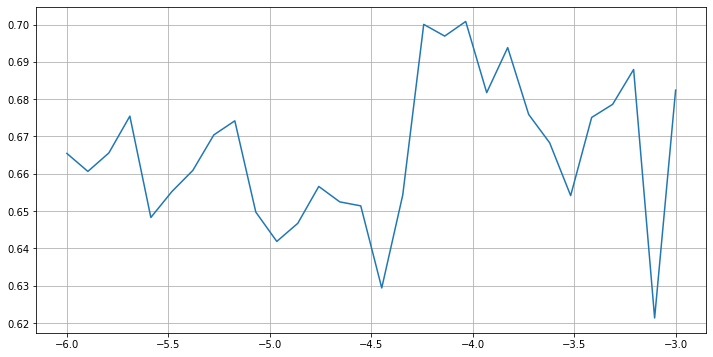

0.01769483024496462 -4.0344827586206895


In [33]:
# Plot CV AUCs
print(cv_aucs)
plt.figure(figsize=(12,6))
plt.plot(np.log(regs), cv_aucs)
plt.grid(axis='both')
plt.show()

max_reg = regs[np.argmax(np.array(cv_aucs))]
print(max_reg, np.log(max_reg))

In [ ]:
# Choose best regularization parameter based on CV plot
optimal_log_reg = -3.45
optimal_reg = np.exp(optimal_log_reg)
print(optimal_log_reg, optimal_reg)

# Fit "optimal model"
optimal_sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=optimal_reg*(1/6), l1_reg=optimal_reg*(5/6), n_iter=1000, 
                         tol=1e-6, old_regularisation=False, warm_start=False, random_state=seed)
optimal_sgl.fit(X_train_2, y_train_2)

# Store optimal model
optimal_sgl_2 = optimal_sgl

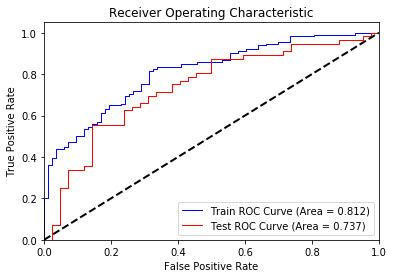

In [17]:
# Plot Train and Test ROCs
y_pred_probs_train = optimal_sgl.predict_proba(X_train_2)[1] # predicted probability y = 1
y_pred_probs_test = optimal_sgl.predict_proba(X_test_2)[1]

# Train
fpr, tpr, thresholds = roc_curve(y_train_2, y_pred_probs_train, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=1, label='Train ROC Curve (Area = %0.3f)' % roc_auc)
training_aurocs[1] = roc_auc

# Test
fpr, tpr, thresholds = roc_curve(y_test_2, y_pred_probs_test, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Test ROC Curve (Area = %0.3f)' % roc_auc)
generalization_aurocs[1] = roc_auc

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

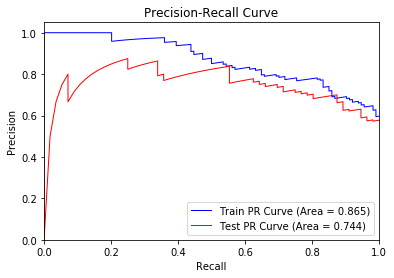

In [18]:
# Plot Train and Test PR Curves

# Train
precision, recall, thresholds = precision_recall_curve(y_train_2, y_pred_probs_train, pos_label=1)
prc_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='blue', lw=1, label='Train PR Curve (Area = %0.3f)' % prc_auc)
training_auprcs[1] = prc_auc

# Test
precision, recall, thresholds = precision_recall_curve(y_test_2, y_pred_probs_test, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Test PR Curve (Area = %0.3f)' % prc_auc)
generalization_auprcs[1] = prc_auc

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [19]:
# Save model coefficients
sparsity_mask = optimal_sgl.sparsity_mask_
print("Number of chosen variables: {0}".format(sparsity_mask.sum()))

betas_2 = optimal_sgl.coef_[:, 1] - optimal_sgl.coef_[:, 0]
betas_2[~sparsity_mask] = 0.0 # if not included in model, set to 0
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta": betas_2, 
    "Cluster": clusters['x'],
    "Included (T/F)": sparsity_mask}
)
betas_df = betas_df[betas_df['Included (T/F)'] == True][['HIF', 'Beta', 'Cluster']]
betas_df.sort_values(by="Beta", ascending=False)

Number of chosen variables: 56


,HIF,Beta,Cluster
517,REGION PROPERTIES: PERIMETER^2 / AREA OF SIGNIFICANT REGIONS OF STROMA_HE,0.234014,1
154,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION MEAN OF FIBROBLAST IN STROMA_HE,0.147708,13
509,REGION PROPERTIES: PERIMETER^2 / AREA OF LARGEST REGION OF ESI_0080_HE,0.147390,1
94,CELL CLUSTERING PROPERTIES: CLUSTER SIZE MEAN OF FIBROBLAST IN STROMA_HE,0.146784,13
174,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION STANDARD DEVIATION OF FIBROBLAST IN STROMA_HE,0.124662,13
596,TOTAL [LYMPHOCYTE CELLS] IN [ESI_0080]_HE,0.111322,1
114,CELL CLUSTERING PROPERTIES: CLUSTER SIZE STANDARD DEVIATION OF FIBROBLAST IN STROMA_HE,0.088292,13
402,DENSITY [FIBROBLAST CELLS] IN [STROMA]_HE,0.061042,13
600,TOTAL [MACROPHAGE CELLS] IN [ESI_0080]_HE,0.049192,1
576,TOTAL [CANCER CELLS] IN [ESI_0080] SELECTED BY [FIBROBLAST_RADIUS_80]_HE,0.034000,1


### Outer Loop 3

In [20]:
# Define outer loop train and test
X_train_3 = np.array(X_train_B.append(X_train_C))
y_train_3 = np.array(y_train_B.append(y_train_C))
print(X_train_3.shape, y_train_3.shape)

X_test_3 = np.array(X_train_A)
y_test_3 = np.array(y_train_A)
print(X_test_3.shape, y_test_3.shape)

(197, 607) (197,)
(98, 607) (98,)


In [30]:
# Define k-folds object
skf = StratifiedKFold(n_splits=num_inner_loops)
skf.get_n_splits(X_train_3, y_train_3)

5

In [ ]:
# K-folds: hyper-parameter tuning
num_regs = 30
regs = list(np.logspace(-6.0, -3.0, num_regs, base=e))
print(regs)

cv_aucs = [] # based on k-folds CV

for reg in regs:
    print(reg)
    k_folds_count = 1
    
    aucs = [] 
    for train_index, test_index in skf.split(X_train_3, y_train_3):
        print(k_folds_count)

        # Define train / test
        X_train, X_test = X_train_3[train_index], X_train_3[test_index]
        y_train, y_test = y_train_3[train_index], y_train_3[test_index]
        print(np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test))
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        
        # SGL 
        sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=reg*(1/6), l1_reg=reg*(5/6), n_iter=1000, 
                                 tol=1e-6, old_regularisation=False, warm_start=True, random_state=seed)
        sgl.fit(X_train, y_train)

        # Compute AUC on test set
        y_probs_test = sgl.predict_proba(X_test)[1] # predicted probability y = 1
        fpr, tpr, thresholds = roc_curve(y_test, y_probs_test, pos_label=1)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        k_folds_count += 1
    
    print(aucs)
    cv_aucs.append(np.mean(np.array(aucs)))

[0.628861970913184, 0.6002464381979207, 0.6284386126003376, 0.6172842925268801, 0.6214943277746512, 0.6273959598353129, 0.6254816208050709, 0.6119074375759012, 0.6248591866354669, 0.6377051923817423, 0.6338829714759634, 0.5868497378632149, 0.6412806788898433, 0.6492841740469772, 0.6387357601966767, 0.6063488936939072, 0.6302116347264596, 0.6533377862030154, 0.6481501732768579, 0.6508866443529517, 0.6621109860489913, 0.6519447587452978, 0.6297309617606114, 0.6364373981813335, 0.6212116051064838, 0.6443538994698024, 0.6504949794141168, 0.6514793993068926, 0.652501229228992, 0.6442629069044163]


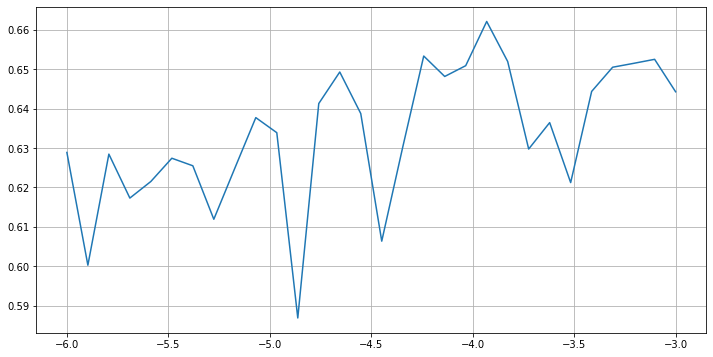

0.019623362019752715 -3.93103448275862


In [55]:
# Plot CV AUCs
print(cv_aucs)
plt.figure(figsize=(12,6))
plt.plot(np.log(regs), cv_aucs)
plt.grid(axis='both')
plt.show()

max_reg = regs[np.argmax(np.array(cv_aucs))]
print(max_reg, np.log(max_reg))

In [ ]:
# Choose best regularization parameter based on CV plot
optimal_log_reg = -3.6
optimal_reg = np.exp(optimal_log_reg)
print(optimal_log_reg, optimal_reg)

# Fit "optimal model"
optimal_sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=optimal_reg*(1/6), l1_reg=optimal_reg*(5/6), n_iter=1000, 
                         tol=1e-6, old_regularisation=False, warm_start=False, random_state=seed)
optimal_sgl.fit(X_train_3, y_train_3)

# Store optimal model
optimal_sgl_3 = optimal_sgl

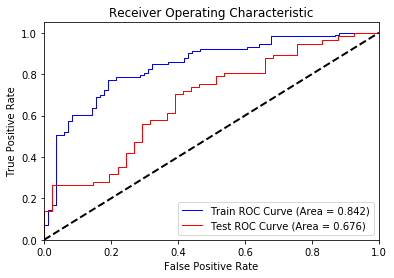

In [22]:
# Plot Train and Test ROCs
y_pred_probs_train = optimal_sgl.predict_proba(X_train_3)[1] # predicted probability y = 1
y_pred_probs_test = optimal_sgl.predict_proba(X_test_3)[1]

# Train
fpr, tpr, thresholds = roc_curve(y_train_3, y_pred_probs_train, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=1, label='Train ROC Curve (Area = %0.3f)' % roc_auc)
training_aurocs[2] = roc_auc

# Test
fpr, tpr, thresholds = roc_curve(y_test_3, y_pred_probs_test, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Test ROC Curve (Area = %0.3f)' % roc_auc)
generalization_aurocs[2] = roc_auc

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

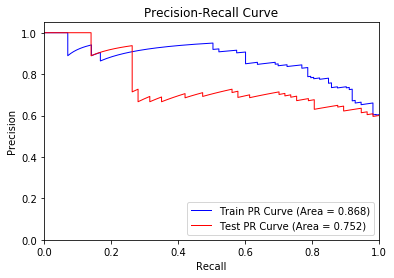

In [23]:
# Plot Train and Test PR Curves

# Train
precision, recall, thresholds = precision_recall_curve(y_train_3, y_pred_probs_train, pos_label=1)
prc_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='blue', lw=1, label='Train PR Curve (Area = %0.3f)' % prc_auc)
training_auprcs[2] = prc_auc

# Test
precision, recall, thresholds = precision_recall_curve(y_test_3, y_pred_probs_test, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Test PR Curve (Area = %0.3f)' % prc_auc)
generalization_auprcs[2] = prc_auc

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [24]:
# Save model coefficients
sparsity_mask = optimal_sgl.sparsity_mask_
print("Number of chosen variables: {0}".format(sparsity_mask.sum()))

betas_3 = optimal_sgl.coef_[:, 1] - optimal_sgl.coef_[:, 0]
betas_3[~sparsity_mask] = 0.0 # if not included in model, set to 0
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta": betas_3, 
    "Cluster": clusters['x'],
    "Included (T/F)": sparsity_mask}
)
betas_df = betas_df[betas_df['Included (T/F)'] == True][['HIF', 'Beta', 'Cluster']]
betas_df.sort_values(by="Beta", ascending=False)

Number of chosen variables: 64


,HIF,Beta,Cluster
242,COUNT PROP [PLASMA CELLS] IN [[STROMA] OVER [EPITHELIAL]]_HE,0.368637,15
563,REGION PROPERTIES: TOTAL MINOR AXIS LENGTH (MM) OF NECROSIS_HE,0.212970,20
203,COUNT PROP [FIBROBLAST CELLS] IN [[ESI_0080] OVER [EPITHELIAL]]_HE,0.133008,15
154,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION MEAN OF FIBROBLAST IN STROMA_HE,0.118651,13
564,REGION PROPERTIES: TOTAL MINOR AXIS LENGTH (MM) OF STROMA_HE,0.116137,20
...,...,...,...
213,COUNT PROP [LYMPHOCYTE CELLS] IN [[EPITHELIAL] OVER [STROMA]]_HE,-0.165238,15
565,REGION PROPERTIES: TOTAL MINOR AXIS LENGTH (MM) OF TUMOR_HE,-0.240593,20
566,REGION PROPERTIES: TOTAL PERIMETER (MM) OF EPITHELIAL_HE,-0.312582,20
212,COUNT PROP [LYMPHOCYTE CELLS] IN [[EPITHELIAL] OVER [ESI_0080]]_HE,-0.316421,15


## Compute Ensemble Model

In [25]:
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta_1": betas_1, 
    "Beta_2": betas_2,
    "Beta_3": betas_3,
    "Cluster": clusters['x']
    }
)
betas_df['Beta'] = (betas_df['Beta_1'] + betas_df['Beta_2'] + betas_df['Beta_3'])/3.0
betas_df.sort_values(by="Beta", ascending=False)

,HIF,Beta_1,Beta_2,Beta_3,Cluster,Beta
242,COUNT PROP [PLASMA CELLS] IN [[STROMA] OVER [EPITHELIAL]]_HE,0.173808,0.000000,0.368637,15,0.180815
154,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION MEAN OF FIBROBLAST IN STROMA_HE,0.116138,0.147708,0.118651,13,0.127499
94,CELL CLUSTERING PROPERTIES: CLUSTER SIZE MEAN OF FIBROBLAST IN STROMA_HE,0.074171,0.146784,0.086054,13,0.102336
174,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION STANDARD DEVIATION OF FIBROBLAST IN STROMA_HE,0.061929,0.124662,0.061803,13,0.082798
517,REGION PROPERTIES: PERIMETER^2 / AREA OF SIGNIFICANT REGIONS OF STROMA_HE,0.000000,0.234014,0.000000,1,0.078005
...,...,...,...,...,...,...
565,REGION PROPERTIES: TOTAL MINOR AXIS LENGTH (MM) OF TUMOR_HE,0.000000,0.000000,-0.240593,20,-0.080198
463,REGION PROPERTIES: FRACTAL DIMENSION OF LARGEST REGION OF EPITHELIAL_HE,-0.252694,0.000000,0.000000,3,-0.084231
566,REGION PROPERTIES: TOTAL PERIMETER (MM) OF EPITHELIAL_HE,0.000000,0.000000,-0.312582,20,-0.104194
212,COUNT PROP [LYMPHOCYTE CELLS] IN [[EPITHELIAL] OVER [ESI_0080]]_HE,0.000000,0.000000,-0.316421,15,-0.105474


## Compute Final Train / Test Metrics

In [26]:
print(training_aurocs)
print(np.mean(training_aurocs), np.std(training_aurocs))

[0.7798272736965561, 0.8115620376241809, 0.8422882427307206]
0.8112258513504859 0.025500691874008406


In [27]:
print(generalization_aurocs)
print(np.mean(generalization_aurocs), np.std(generalization_aurocs))

[0.70843776106934, 0.7372448979591836, 0.6756525459991441]
0.7071117350092225 0.02516244839473332


In [28]:
print(training_auprcs)
print(np.mean(training_auprcs), np.std(training_auprcs))

[0.8146741078279194, 0.8650646960883109, 0.8675713131691674]
0.8491033723617992 0.024366664038605663


In [29]:
print(generalization_auprcs)
print(np.mean(generalization_auprcs), np.std(generalization_auprcs))

[0.7939316021095164, 0.7443198904559057, 0.7524899286367623]
0.7635804737340615 0.02171912561494549


## Evaluate Hold-Out Set

In [30]:
holdout_df = pd.read_csv("{0}/data/genetic_data/PanImmune/datasets/luad.PDL1.joined.HOLDOUT.csv".format(working_dir))
holdout_df = holdout_df.iloc[:,1:]
holdout_df

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._HE,AREA..MM2..OF..ESI_0080..IN..TISSUE._HE,AREA..MM2..OF..NECROSIS..IN..TISSUE._HE,AREA..MM2..OF..STROMA..IN..TISSUE._HE,AREA..MM2..OF..TUMOR..IN..TISSUE._HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.STROMA_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.TUMOR_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.FIBROBLAST.IN.EPITHELIAL_HE,...,DENSITY..LYMPHOCYTE.CELLS..IN..TUMOR._HE,DENSITY..MACROPHAGE.CELLS..IN..EPITHELIAL._HE,DENSITY..MACROPHAGE.CELLS..IN..ESI_0080._HE,DENSITY..MACROPHAGE.CELLS..IN..STROMA._HE,DENSITY..MACROPHAGE.CELLS..IN..TUMOR._HE,DENSITY..PLASMA.CELLS..IN..EPITHELIAL._HE,DENSITY..PLASMA.CELLS..IN..ESI_0080._HE,DENSITY..PLASMA.CELLS..IN..STROMA._HE,DENSITY..PLASMA.CELLS..IN..TUMOR._HE,joined.PDL1_data
0,136.661136,159.244844,13.627104,124.760496,261.421632,6569.555773,6196.871210,5883.111381,6845.927703,6511.041537,...,324.892777,267.874255,300.876303,400.311009,331.078187,183.841586,300.662796,435.233922,303.815715,1
1,39.920912,69.314676,5.315152,64.545840,104.466752,6519.085240,6684.527789,6467.939404,6743.460348,5011.467504,...,617.804218,121.064368,412.986133,855.887847,575.082491,65.679862,750.461562,1296.954227,826.435190,1
2,62.302536,129.819836,5.933816,178.632208,240.934744,6336.653660,6287.289649,6727.715056,6762.129199,5006.195021,...,2372.671498,189.446542,488.607920,856.816370,684.243365,193.988893,762.133146,877.585301,700.816317,0
3,74.309088,125.439476,12.137280,166.299872,240.608960,5699.687863,6511.093987,5531.920743,6012.873158,5063.523013,...,1480.244127,152.282854,428.031125,747.120238,563.412102,139.242726,794.143942,828.449225,615.596360,1
4,67.641900,95.316000,31.037048,54.533612,122.175512,6456.923068,6873.572132,6193.082487,6650.332045,6189.983149,...,288.895863,22.826089,167.254186,433.604141,206.178796,65.211060,129.254270,236.276299,141.566831,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,16.295424,22.866624,3.175088,12.735248,29.030672,7410.985019,7204.818710,6976.726907,7460.400035,6296.664491,...,1199.455528,171.459178,442.347764,909.601446,495.269279,155.994714,654.316090,1670.481800,820.373707,1
91,96.848160,54.131324,13.223424,21.179504,118.027664,7320.798988,6005.536544,5830.458945,7213.837199,5145.353655,...,80.260845,8.311980,69.811705,433.060189,84.531030,3.851390,37.187341,143.251702,28.866114,0
92,8.241392,11.694380,6.631776,10.866672,19.108064,5981.225129,6573.416890,5682.214054,6185.403365,5174.081836,...,706.350994,295.702474,491.518148,810.551749,588.494994,248.259032,1005.183687,1339.048423,868.586163,1
93,3.746672,8.019604,2.764032,10.716912,14.463584,6380.083503,6371.211659,6912.881810,6738.488914,6184.440881,...,355.928378,111.031870,167.963406,228.610630,198.152823,185.231053,463.863303,493.705650,413.797853,0


In [31]:
# Normalize HIFs and define X, y
X_holdout = holdout_df.iloc[:,:607]
X_normalized_holdout = (X_holdout-X_holdout.mean())/X_holdout.std()
X_normalized_holdout

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._HE,AREA..MM2..OF..ESI_0080..IN..TISSUE._HE,AREA..MM2..OF..NECROSIS..IN..TISSUE._HE,AREA..MM2..OF..STROMA..IN..TISSUE._HE,AREA..MM2..OF..TUMOR..IN..TISSUE._HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.STROMA_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.TUMOR_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.FIBROBLAST.IN.EPITHELIAL_HE,...,DENSITY..LYMPHOCYTE.CELLS..IN..STROMA._HE,DENSITY..LYMPHOCYTE.CELLS..IN..TUMOR._HE,DENSITY..MACROPHAGE.CELLS..IN..EPITHELIAL._HE,DENSITY..MACROPHAGE.CELLS..IN..ESI_0080._HE,DENSITY..MACROPHAGE.CELLS..IN..STROMA._HE,DENSITY..MACROPHAGE.CELLS..IN..TUMOR._HE,DENSITY..PLASMA.CELLS..IN..EPITHELIAL._HE,DENSITY..PLASMA.CELLS..IN..ESI_0080._HE,DENSITY..PLASMA.CELLS..IN..STROMA._HE,DENSITY..PLASMA.CELLS..IN..TUMOR._HE
0,3.614228,3.170403,0.706686,2.806389,3.533173,0.251646,-0.282006,-0.245824,0.457786,1.405122,...,-1.174405,-0.947738,-0.012583,-0.494030,-1.080854,-0.681668,0.057461,-0.684984,-0.786190,-0.689770
1,0.374051,0.818779,-0.184282,1.010980,0.788277,0.169756,0.488734,0.556413,0.267472,-0.808721,...,-0.524716,-0.372168,-0.795462,0.052918,0.587577,0.412935,-0.705311,0.247270,0.332202,0.499387
2,1.123692,2.400956,-0.117967,4.412672,3.174889,-0.126245,-0.139100,0.912760,0.302146,-0.816505,...,2.187105,3.076138,-0.430807,0.421852,0.590977,0.902630,0.122965,0.271460,-0.212080,0.213557
3,1.525835,2.286412,0.546990,4.044961,3.169192,-1.159741,0.214622,-0.727570,-1.089456,-0.731871,...,0.850254,1.322522,-0.628986,0.126317,0.189244,0.360582,-0.230439,0.337806,-0.275852,0.019649
4,1.302527,1.498699,2.572879,0.712447,1.097976,0.068896,0.787519,0.179378,0.094503,0.931139,...,-1.043747,-1.018471,-1.319328,-1.145929,-0.958927,-1.241966,-0.708337,-1.040246,-1.044409,-1.058948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,-0.417251,-0.395812,-0.413678,-0.533847,-0.530982,1.616890,1.311053,1.254342,1.599052,1.088634,...,1.118986,0.770774,-0.526727,0.196164,0.784289,0.054893,-0.122300,0.047999,0.816988,0.485595
91,2.280749,0.421743,0.663415,-0.282066,1.025437,1.470560,-0.584410,-0.318050,1.141108,-0.611063,...,-1.259716,-1.428438,-1.396726,-1.621319,-0.960919,-1.787678,-1.104434,-1.231064,-1.165142,-1.315385
92,-0.687009,-0.687960,-0.043152,-0.589562,-0.704512,-0.702938,0.313124,-0.521405,-0.769014,-0.568651,...,-0.395702,-0.198174,0.135814,0.436050,0.421545,0.473103,0.473296,0.775208,0.386834,0.595297
93,-0.837554,-0.784053,-0.457740,-0.594027,-0.785737,-0.055779,-0.006461,1.166763,0.258238,0.922957,...,-1.190462,-0.886753,-0.848962,-1.142469,-1.709662,-1.277971,0.066430,-0.346734,-0.710302,-0.439519


In [32]:
y_holdout = holdout_df.iloc[:,607]
print(np.sum(y_holdout))

60


In [33]:
X_normalized_holdout = np.array(X_normalized_holdout)
y_pred_probs_1 = optimal_sgl_1.predict_proba(X_normalized_holdout)[1] # predicted probability y = 1
y_pred_probs_2 = optimal_sgl_2.predict_proba(X_normalized_holdout)[1]
y_pred_probs_3 = optimal_sgl_3.predict_proba(X_normalized_holdout)[1] 

In [34]:
# Ensemble (average) predictions
y_pred_probs_ensemble = np.mean(np.array([list(y_pred_probs_1), list(y_pred_probs_2), list(y_pred_probs_3)]), axis=0)
# y_pred_probs_ensemble

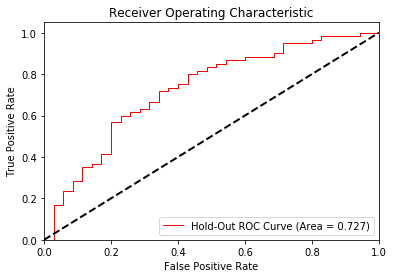

In [35]:
# Hold Out ROC
fpr, tpr, thresholds = roc_curve(y_holdout, y_pred_probs_ensemble, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Hold-Out ROC Curve (Area = %0.3f)' % roc_auc)

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Original ROC area: 0.727


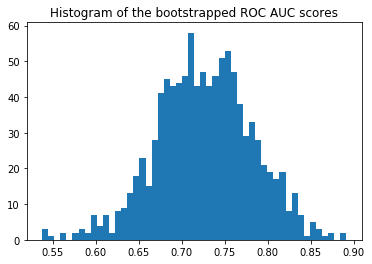

Confidence interval for the score: [0.610 - 0.832]


In [36]:
# Generate ROC 95% CI

print("Original ROC area: {:0.3f}".format(roc_auc))

n_bootstraps = 1000
bootstrapped_scores = []

rng = np.random.RandomState(seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred_probs_ensemble), len(y_pred_probs_ensemble))
    
    if len(np.unique(y_holdout[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_holdout[indices], y_pred_probs_ensemble[indices])
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 94% confidence interval
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

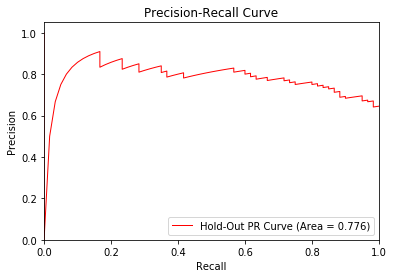

In [37]:
# Hold Out PR Curve
precision, recall, thresholds = precision_recall_curve(y_holdout, y_pred_probs_ensemble, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Hold-Out PR Curve (Area = %0.3f)' % prc_auc)

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

Original PRC area: 0.776


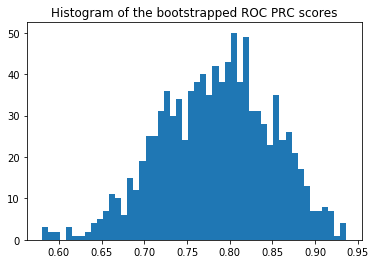

Confidence interval for the score: [0.653 - 0.903]


In [38]:
# Generate PRC 95% CI
print("Original PRC area: {:0.3f}".format(prc_auc))

n_bootstraps = 1000
bootstrapped_scores = []

rng = np.random.RandomState(seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred_probs_ensemble), len(y_pred_probs_ensemble))
    
    if len(np.unique(y_holdout[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    precision, recall, thresholds = precision_recall_curve(y_holdout[indices], y_pred_probs_ensemble[indices], pos_label=1)
    score = auc(recall, precision)
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC PRC scores')
plt.show()

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 94% confidence interval
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))